# Project 7 - Traffic Sign Detection 
### Using **VGG19** 
### Train/Validation/Test Accuracy : **97.25%**, **91.57%**, **56.23%**

- Course Name :         Applied Machine Learning
- Course instructor:    Sohail Tehranipour
- Student Name :        Afshin Masoudi Ashtiani
- Project 7 :           Traffic Sign Detection
- Date :                September 2024
- Files :               3/4

## Step 1 : Install required libraries

In [35]:
%pip install numpy pandas
%pip install matplotlib seaborn plotly
%pip install opencv-python
%pip install tensorflow keras scikit-learn
%pip install pillow pathlib

## Step 2 : Import required libraries

In [2]:
# Fundamental classes
import os
import numpy as np
import pandas as pd
import tensorflow as tf
%matplotlib inline

# Mount google drive
# from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# Warnings
import warnings
warnings.filterwarnings('ignore')

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


### Step 3 : Load dataset (Traffic Signs Images)

- Define required parameters

In [3]:
# Path the data
data_dir = r'C:/Users/Afshin/Desktop/10_Projects/Project_7_Traffic_Sign_Detection/datasets/'
# data_dir = '/content/drive/My Drive/Applied Machine Learning/Project 7 : Traffic Sign Detection/datasets/'
# data_dir = '/kaggle/input/gtsrb-german-traffic-sign/'

train_path = data_dir + 'Train'
test_path = data_dir + 'Test'
train_csv_path = data_dir + 'Train.csv'
test_csv_path = data_dir + 'Test.csv'
img_height, img_width = 50, 50
num_classes = len(os.listdir(train_path))
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

- Load and prepare the Train and Test datasets

In [4]:
# Importing the dataset
import cv2
from PIL import Image
from tqdm import tqdm

def load_prepare_dataset(csv_path, data_dir, height, width):
    data = pd.read_csv(csv_path)[['ClassId', 'Path']]
    data['Path'] = data_dir + data['Path']

    labels, images = [], [] 

    # Retreiving the images
    with tf.device('/GPU:0'):
        for index, row in tqdm(data.iterrows(), total=data.shape[0], desc="> Loading images"):
            img_path = row['Path']
            img_label = row['ClassId']
            # Check if the file exists and is a valid image
            if os.path.isfile(img_path) and img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                try:
                    image = cv2.imread(img_path)
                    if image is not None:
                        image_fromarray = Image.fromarray(image, 'RGB')
                        # Resize the image 
                        resize_image = image_fromarray.resize((height, width))
                        # Normalize the image to range [0, 1]
                        resize_image = np.array(resize_image) / 255.0  # Normalize pixels
                        images.append(resize_image)
                        labels.append(img_label)
                    else:
                        print(f">> Error reading image: {img_path}")
                except Exception as e:
                    print(f">> Error processing image: {img_path}")
                    print(e)
            else:
                print(f">> Image not found or not a PNG file: {img_path}")

    return np.array(images), np.array(labels), data

In [6]:
train_images, train_labels, train_df = load_prepare_dataset(train_csv_path, data_dir, img_height, img_width)
test_images, test_labels, test_df = load_prepare_dataset(test_csv_path, data_dir, img_height, img_width)

# Checking data shape
print(f'> Shape of Train images, labels and data: {train_images.shape}, {train_labels.shape} and {train_df.shape}')
print(f'> Shape of Test  images, labels and data: {test_images.shape}, {test_labels.shape} and {test_df.shape}')

> Loading images: 100%|██████████| 12630/12630 [02:42<00:00, 77.71it/s] 


> Shape of Train images, labels and data: (39209, 50, 50, 3), (39209,) and (39209, 2)
> Shape of Test  images, labels and data: (12630, 50, 50, 3), (12630,) and (12630, 2)


## Step 4 : Split the dataset into Train and Validation sets

- Split the dataset

In [22]:
from keras import utils
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_validation, y_train, y_validation = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Converting the labels into one-hot encoding
y_train_encoded = utils.to_categorical(y_train, num_classes)
y_validation_encoded = utils.to_categorical(y_validation, num_classes)

# Displaying the shape after the split
print(f"> Train      images and labels shape : {X_train.shape} and {y_train.shape}")
print(f"> Validation images and labels shape : {X_validation.shape} and {y_validation.shape}")

# Display the shape after one-hot encoding
print(f"> One-hot encoded Train       labels shape: {y_train_encoded.shape}")
print(f"> One-hot encoded Validation  labels shape: {y_validation_encoded.shape}")

> Train      images and labels shape : (31367, 50, 50, 3) and (31367,)
> Validation images and labels shape : (7842, 50, 50, 3) and (7842,)
> One-hot encoded Train       labels shape: (31367, 43)
> One-hot encoded Validation  labels shape: (7842, 43)


## Step 5 : Build and Compile a model

- Create a VGG19 model

In [27]:
from keras import Sequential, layers, applications, optimizers

def create_vgg19_model(input_shape=(50, 50, 3), num_classes=43, learning_rate=0.001):
    # Load VGG19 model - Path of the VGG19 weights file
    weights = r"C:/Users/Afshin/Desktop/10_Projects/Project_7_Traffic_Sign_Detection/models/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
    # weights = 'imagenet'

    # Load the VGG19 model with the downloaded weights
    base_model = applications.VGG19(weights=weights, include_top=False, input_shape=input_shape)

    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print(">>>> VGG19 model summary :")
    print(model.summary())

    return model

In [28]:
# Model parameters
input_shape = (img_height, img_width, 3)  # Shape of input data (height, width, channels)
learning_rate = 0.0005

# Create a VGG19 model
vgg19_model = create_vgg19_model(input_shape, num_classes, learning_rate)

>>>> VGG19 model summary :


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 1, 1, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 1, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,311,147 (77.48 MB)

 Trainable params: 285,739 (1.09 MB)

 Non-trainable params: 20,025,408 (76.39 MB)

None


- Fit the model

In [29]:
# Training settings
epochs = 15

# Fit the model
with tf.device('/GPU:0'):
    vgg19_history = vgg19_model.fit(
        X_train,
        y_train_encoded,
        epochs=epochs,
        validation_data=(X_validation, y_validation_encoded))

Epoch 1/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 1883s 2s/step - accuracy: 0.4655 - loss: 1.8629 - val_accuracy: 0.7158 - val_loss: 0.9039
Epoch 2/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 1857s 2s/step - accuracy: 0.7413 - loss: 0.8318 - val_accuracy: 0.7913 - val_loss: 0.6652
Epoch 3/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 1843s 2s/step - accuracy: 0.8092 - loss: 0.6115 - val_accuracy: 0.8267 - val_loss: 0.5488
Epoch 4/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 1668s 2s/step - accuracy: 0.8429 - loss: 0.4962 - val_accuracy: 0.8381 - val_loss: 0.5112
Epoch 5/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 1694s 2s/step - accuracy: 0.8717 - loss: 0.4089 - val_accuracy: 0.8665 - val_loss: 0.4258
Epoch 6/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 1720s 2s/step - accuracy: 0.8882 - loss: 0.3557 - val_accuracy: 0.8768 - val_loss: 0.4030
Epoch 7/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 1636s 2s/step - accuracy: 0.9012 - loss: 0.3109 - val_accuracy: 0.8805 - val_loss: 0.3790
Epoch 8/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 1689s 2s/step - accuracy: 0.9092 - loss: 0.2838 - 

- Display training history

In [30]:
import matplotlib.pyplot as plt
from datetime import datetime

def plot_performance(history=None, model_name:str=None, figure_directory:str=None, ylim_pad=[0, 0], figsize=(20, 5), show_grid=True):
    if history is None:
        raise ValueError(f"The {model_name}-history object must be provided.")

    xlabel = 'Epoch'

    plt.figure(figsize=figsize)

    metrics = [('accuracy', 'Accuracy'), ('loss', 'Loss')]

    for i, (metric, title) in enumerate(metrics):
        y1 = history.history[metric]
        y2 = history.history[f'val_{metric}']

        min_y = min(min(y1), min(y2)) - ylim_pad[i]
        max_y = max(max(y1), max(y2)) + ylim_pad[i]

        plt.subplot(1, 2, i + 1)
        plt.plot(y1, label='Training')
        plt.plot(y2, label='Validation')

        plt.title(f'{model_name} Model {title}\n{datetime.now().strftime(f"%Y-%m-%d %H:%M:%S")}', fontsize=17)
        plt.xlabel(xlabel, fontsize=15)
        plt.ylabel(title, fontsize=15)
        plt.ylim(min_y, max_y)
        plt.legend(loc='upper left')

        if show_grid:
            plt.grid()

    if figure_directory:
        plt.savefig(f"{figure_directory}/{model_name}_training_history.png")  # Ensure the directory has an appropriate filename

    plt.tight_layout()  # Adjust subplots to fit into figure area.
    plt.show()

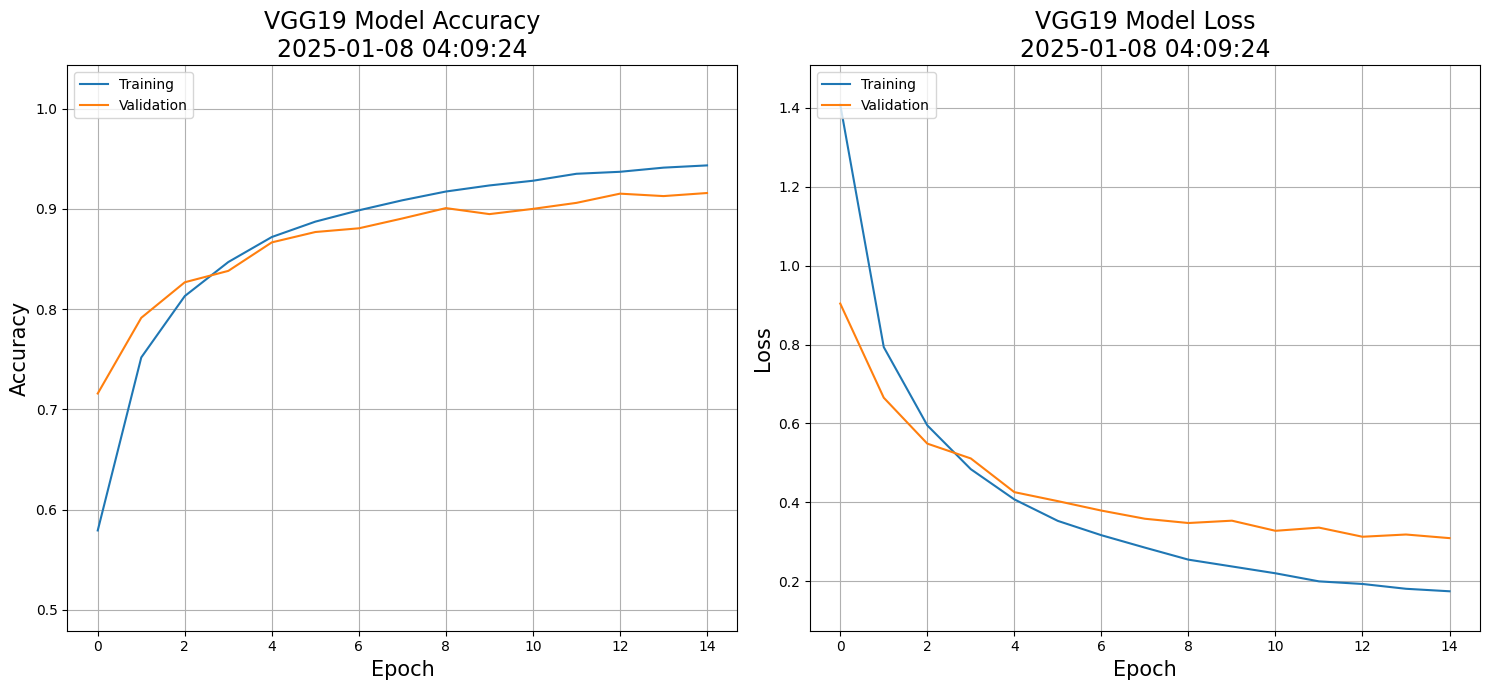

In [31]:
figure_dir = r'C:/Users/Afshin/Desktop/10_Projects/Project_7_Traffic_Sign_Detection/plots'
# figure_dir = '/content/drive/My Drive/Applied Machine Learning/Project 7 : Traffic Sign Detection/plots'
# figure_dir = '/kaggle/working'

plot_performance(vgg19_history, 'VGG19', figure_directory=figure_dir, ylim_pad=[0.1, 0.1], figsize=(15, 7), show_grid=True)

## Step 6 : Evaluate the model

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

def predict_data(model, name, X, y):
    if model is None:
        raise ValueError(f"The model object must be provided.")

    # Get model predictions
    y_pred = np.argmax(model.predict(X), axis=1)
    report = classification_report(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    
    # Print performance metrics
    print(f'>>>> {name} dataset :')
    print(f'>  Accuracy Score        : {(accuracy * 100):.2f}%')
    print(f'>  F1       Score        : {(f1 * 100):.2f}%')
    print(f'>  Classification Report :\n{report}')

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='3g')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

    return accuracy, f1, y_pred

981/981 ━━━━━━━━━━━━━━━━━━━━ 2543s 3s/step
>>>> Train dataset :
>  Accuracy Score        : 97.26%
>  F1       Score        : 97.26%
>  Classification Report :
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       166
           1       1.00      0.97      0.98      1746
           2       0.97      0.99      0.98      1798
           3       0.97      0.89      0.93      1115
           4       0.91      0.94      0.92      1560
           5       0.98      0.93      0.95      1528
           6       1.00      1.00      1.00       338
           7       0.92      0.94      0.93      1164
           8       0.89      0.91      0.90      1127
           9       0.97      0.98      0.98      1166
          10       0.91      0.98      0.94      1661
          11       0.98      0.99      0.98      1078
          12       1.00      1.00      1.00      1646
          13       0.99      1.00      1.00      1719
          14       1.00      1

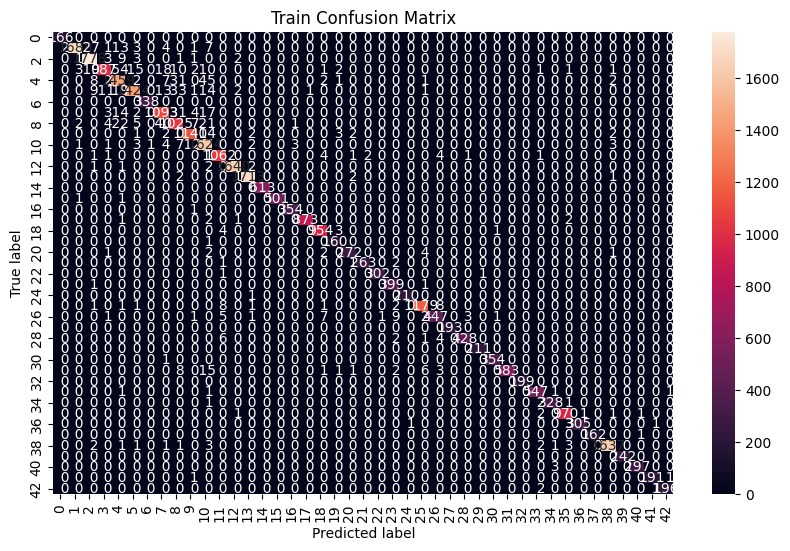

246/246 ━━━━━━━━━━━━━━━━━━━━ 645s 3s/step
>>>> Validation dataset :
>  Accuracy Score        : 91.57%
>  F1       Score        : 91.55%
>  Classification Report :
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        44
           1       0.94      0.86      0.90       474
           2       0.87      0.94      0.90       452
           3       0.90      0.73      0.81       295
           4       0.82      0.87      0.84       420
           5       0.90      0.87      0.88       332
           6       1.00      0.93      0.96        82
           7       0.88      0.88      0.88       276
           8       0.86      0.84      0.85       283
           9       0.90      0.95      0.92       304
          10       0.83      0.94      0.88       349
          11       0.84      0.94      0.89       242
          12       0.98      0.98      0.98       454
          13       0.97      0.98      0.98       441
          14       1.00   

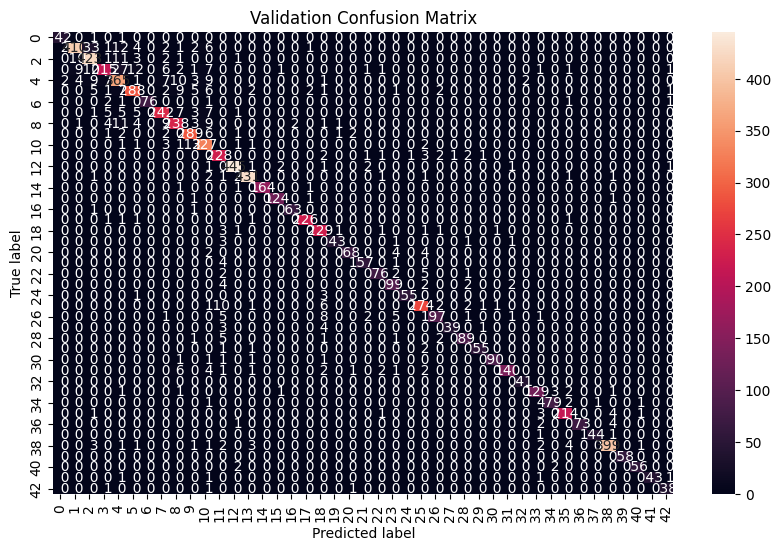

395/395 ━━━━━━━━━━━━━━━━━━━━ 1048s 3s/step
>>>> Test dataset :
>  Accuracy Score        : 56.23%
>  F1       Score        : 55.52%
>  Classification Report :
              precision    recall  f1-score   support

           0       0.29      0.22      0.25        60
           1       0.57      0.45      0.51       720
           2       0.38      0.50      0.43       750
           3       0.19      0.12      0.15       450
           4       0.39      0.46      0.42       660
           5       0.47      0.56      0.51       630
           6       0.86      0.53      0.65       150
           7       0.50      0.62      0.55       450
           8       0.34      0.25      0.29       450
           9       0.69      0.67      0.68       480
          10       0.65      0.75      0.70       660
          11       0.36      0.56      0.43       420
          12       0.86      0.88      0.87       690
          13       0.87      0.94      0.91       720
          14       0.98      0.

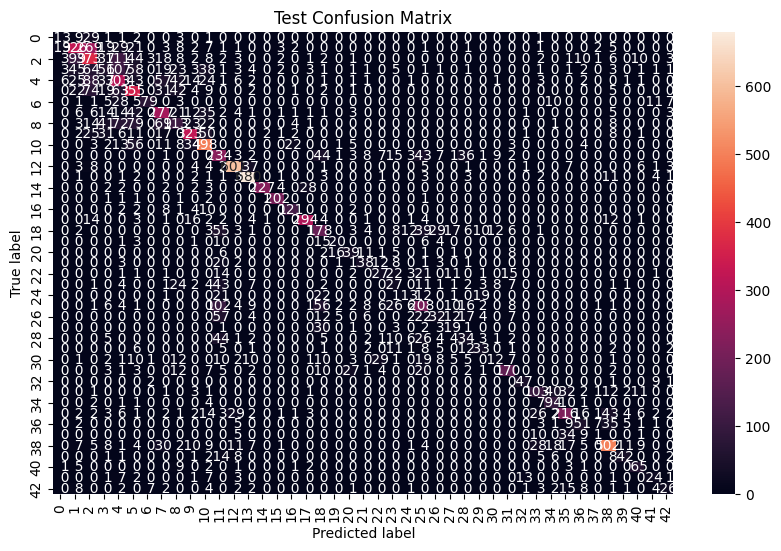

>>>> Results of VGG19 model : 


,Accuracy Score,F1 Score
Train,0.972583,0.972602
Validation,0.915710,0.915542
Test,0.562312,0.555158


In [33]:
train_accuracy, train_f1, y_train_pred = predict_data(vgg19_model, 'Train', X_train, y_train)
validation_accuracy, validation_f1, y_validation_pred = predict_data(vgg19_model, 'Validation', X_validation, y_validation)
test_accuracy, test_f1, y_test_pred = predict_data(vgg19_model, 'Test', test_images, test_labels)

evaluations_df = pd.DataFrame({ 
    'Accuracy Score' : [train_accuracy, validation_accuracy, test_accuracy],
    'F1 Score' : [train_f1, validation_f1, test_f1]}, index= ['Train', 'Validation', 'Test'])

print('>>>> Results of VGG19 model : ')
evaluations_df

## Step 7 : Visualize predictions

In [34]:
import random
import matplotlib.pyplot as plt  # Make sure to import matplotlib for plotting

def visualize_prediction(images:np.array, labels:np.array, predicted_labels:np.array, classes:dict, rows:int, cols:int):
    fig, ax = plt.subplots(rows, cols, figsize=(16, 12))
    for i in range(rows):
        for j in range(cols):
            # Ensure we select a random index correctly
            index = random.randint(0, len(images) - 1)  # Use len(images) - 1 to avoid index out of range
            ax[i, j].imshow(images[index])
            actual = labels[index]
            predicted = predicted_labels[index]

            # Set title with the correct class mapping
            title_color = 'green' if actual == predicted else 'red'
            ax[i, j].set_title(f'Actual: {classes[actual]}\nPredicted: {classes[predicted]}', color=title_color)
            ax[i, j].axis('off')  # Optional: turn off axes for clarity

    plt.tight_layout()
    plt.show()

>>>> Test dataset predictions using VGG19 model : 


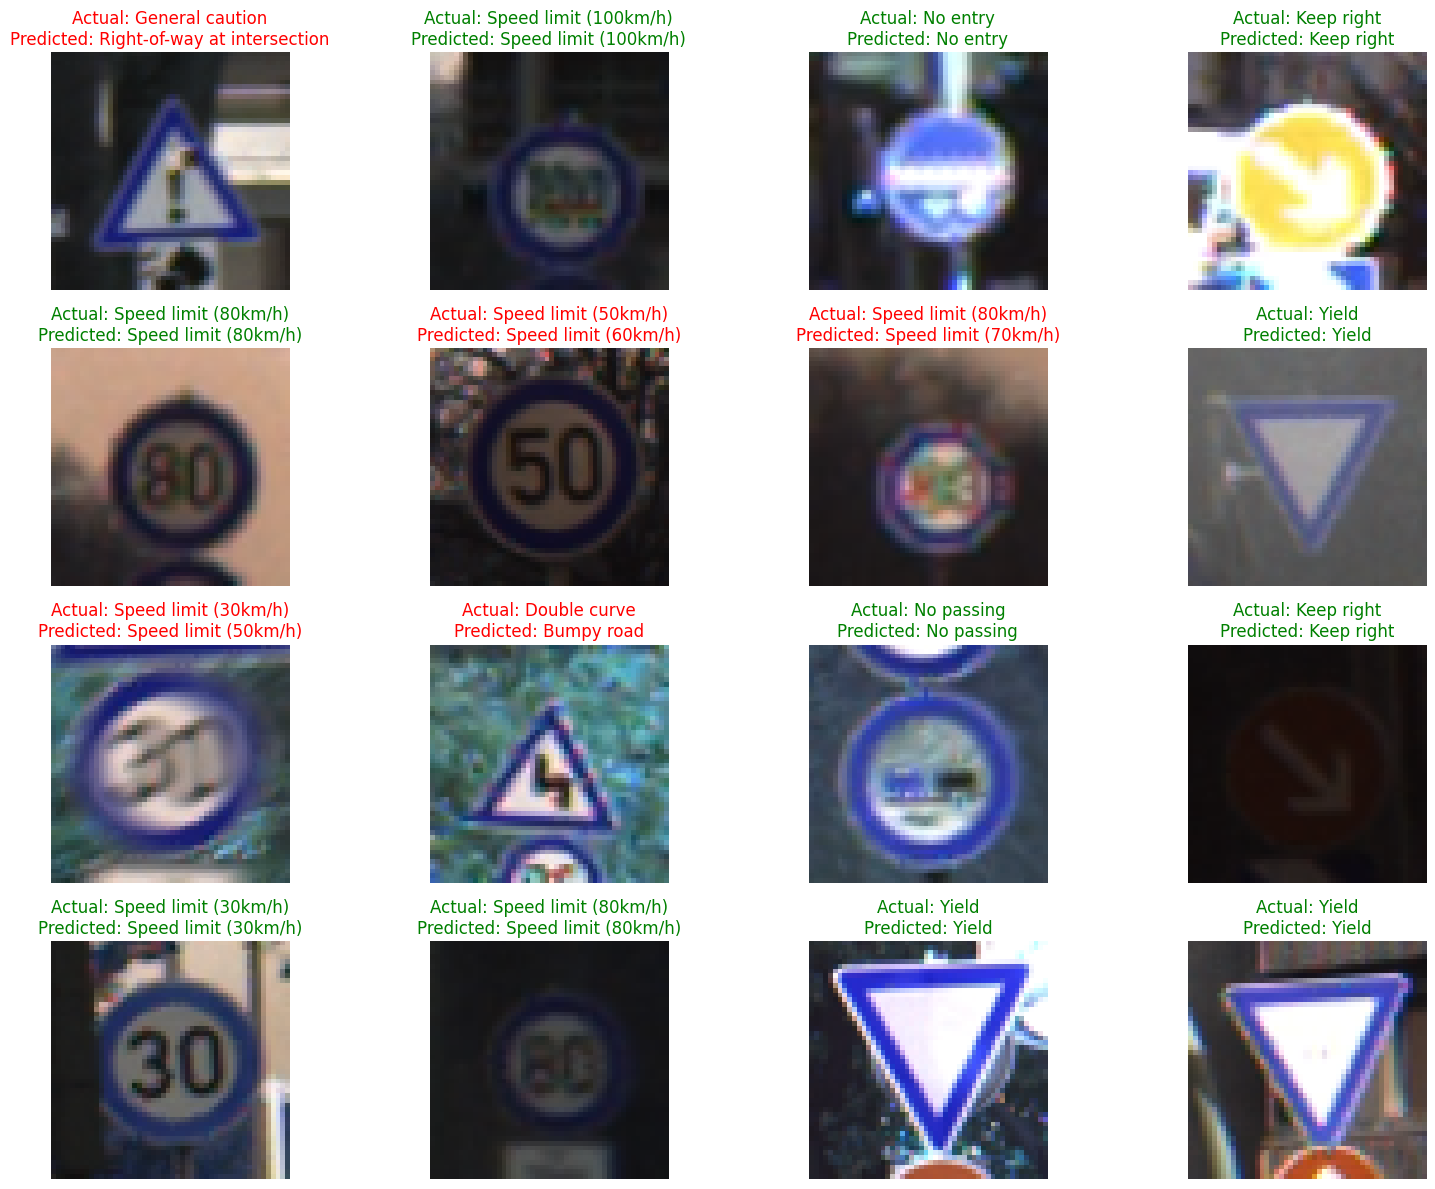

In [35]:
print('>>>> Test dataset predictions using VGG19 model : ')
rows, cols = 4, 4
visualize_prediction(test_images, test_labels, y_test_pred, classes, rows, cols)

## Step 8 : Save the model

In [36]:
# Optionally, save the model
model_path = r'C:/Users/Afshin/Desktop/10_Projects/Project_7_Traffic_Sign_Detection/models/'
# model_path = '/content/drive/My Drive/Applied Machine Learning/Project 7 : Traffic Sign Detection/models/'
# model_path = '/kaggle/working/'

vgg19_model_path = model_path + 'vgg19_model.keras'
vgg19_model.save(vgg19_model_path)
print(f'> The model saved to {vgg19_model_path}.')

> The model saved to C:/Users/Afshin/Desktop/10_Projects/Project_7_Traffic_Sign_Detection/models/vgg19_model.keras.
